In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("df_kaggle_test.csv")

In [3]:
df.head()

,Text,Emotion
0,"There was amusement in Jake 's voice , but the...",happy
1,i feel it is too dangerous to invest in such m...,anger
2,i feel that i should write the company and tel...,sadness
3,i also feel ashamed at the hurt caused and ash...,sadness
4,i just yearned for that homey feeling where yo...,love


In [4]:
df.shape

(4292, 2)

In [5]:
df.head()

,Text,Emotion
0,"There was amusement in Jake 's voice , but the...",happy
1,i feel it is too dangerous to invest in such m...,anger
2,i feel that i should write the company and tel...,sadness
3,i also feel ashamed at the hurt caused and ash...,sadness
4,i just yearned for that homey feeling where yo...,love


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
y=df.pop("target")
X=df

y.replace(["happy","sadness","anger","fear","love","surprise"],[0,1,2,3,4,5],inplace=True)
y.replace(["happy","sadness","anger","fear","love","surprise"],[0,1,2,3,4,5],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LogisticRegression()
model = lr.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.56      0.79      0.66      2247
           1       0.51      0.65      0.57      2126
           2       0.47      0.28      0.35       997
           3       0.45      0.20      0.28       877
           4       0.44      0.13      0.20       549
           5       0.41      0.12      0.19       286

    accuracy                           0.52      7082
   macro avg       0.47      0.36      0.37      7082
weighted avg       0.50      0.52      0.48      7082



/home/florian/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# test model rnn

In [5]:
y = df.pop("Emotion")
X=df

prepocessing text hero

In [6]:
import texthero as hero

df['clean_text'] = hero.clean(df['Text'])

default_stopwords = hero.stopwords.DEFAULT
default_stopwords.remove("not")
custom_stopwords = default_stopwords.union(set(["feel","feeling","like","im"]))

df['clean_text_stop'] = hero.remove_stopwords(df['clean_text'], custom_stopwords)

In [7]:
# on garde les not
sum(["not" in x for x in df["clean_text_stop"]])

121

embeding

In [9]:
from keras.preprocessing.text import Tokenizer
vocab_size = 20000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)

X = df["clean_text_stop"]

tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [10]:
print(len(tokenizer.word_index))
max([len(t.split()) for t in X])

7884


32

In [11]:
# transforme le texte en une liste de nombres (via le dico)
X_sequences = tokenizer.texts_to_sequences(X)


# padding : toutes les lignes doivent faire 100
max_length = 32
padding_type='post'
truncation_type='post'

from keras.preprocessing.sequence import pad_sequences

X_padded = pad_sequences(X_sequences,maxlen=max_length,padding=padding_type, truncating=truncation_type)

In [12]:
# on charge les poids des mots via le ficher glove
import numpy as np
embeddings_index = {}
f = open('glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
emb_length = 100
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# embeding matrix : les poids du modele glove pour les mots de notre texte
embedding_matrix = np.zeros((len(word_index) + 1,emb_length ))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
from keras.utils import np_utils
y.replace(["happy","sadness","anger","fear","love","surprise"],[0,1,2,3,4,5],inplace=True)

dummy_y = np_utils.to_categorical( y)


In [40]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=emb_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)


model = Sequential([
    embedding_layer,
    LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True),
    LSTM(100,dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(128, activation='relu'),
   Dense(6, activation='softmax')
])


des pistes :
- glove 100 -> ca améliore bien
- plus de neurones sur le lstm : 100->amelioration, tjr du mal avec surprise
- plus de couches
- 2 lstm
- est ce que le reseau apprend ?

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, dummy_y, test_size=0.2, random_state=42)

model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

%load_ext tensorboard

#rm -rf logs

log_folder = 'logs2/drop02'
callbacks = [
            EarlyStopping(min_delta=0.001,patience = 10,restore_best_weights=True),
            TensorBoard(log_dir=log_folder, histogram_freq=1)
            ]


history = model.fit(X_train,y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/100
108/108 [==============================] - 9s 78ms/step - loss: 0.4308 - accuracy: 0.8608 - val_loss: 0.6318 - val_accuracy: 0.8009
Epoch 2/100
108/108 [==============================] - 8s 75ms/step - loss: 0.3944 - accuracy: 0.8678 - val_loss: 0.6795 - val_accuracy: 0.7811
Epoch 3/100
108/108 [==============================] - 7s 65ms/step - loss: 0.3857 - accuracy: 0.8730 - val_loss: 0.6312 - val_accuracy: 0.8114
Epoch 4/100
108/108 [==============================] - 7s 66ms/step - loss: 0.3679 - accuracy: 0.8765 - val_loss: 0.6323 - val_accuracy: 0.8021
Epoch 5/100
108/108 [==============================] - 7s 67ms/step - loss: 0.3490 - accuracy: 0.8832 - val_loss: 0.6476 - val_accuracy: 0.7939
Epoch 6/100
108/108 [==============================] - 7s 67ms/step - loss: 0.3308 - accuracy: 0.8954 - val_loss: 0.6291 - val_accuracy: 0.8009
Epoch 7/100
108/108 [=========================

test

In [91]:
from sklearn.metrics import classification_report

df_test = pd.read_csv("df_kaggle_test.csv")
y_t = df_test.pop("Emotion")

df_test['clean_text'] = hero.clean(df_test['Text'])
df_test['clean_text_stop'] = hero.remove_stopwords(df_test['clean_text'], custom_stopwords)

X_t_sequences = tokenizer.texts_to_sequences(df_test['clean_text_stop'])
X_t_padded = pad_sequences(X_t_sequences,maxlen=max_length,padding=padding_type, truncating=truncation_type)

y_t.replace(["happy","sadness","anger","fear","love","surprise"],[0,1,2,3,4,5],inplace=True)
dummy_y_t = np_utils.to_categorical(y_t)

y_pred = model.predict(X_t_padded)
y_pred[y_pred>=0.5]=1
y_pred[y_pred<0.5]=0
print(classification_report(dummy_y_t,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1381
           1       0.92      0.87      0.90      1277
           2       0.91      0.81      0.86       617
           3       0.85      0.78      0.81       531
           4       0.73      0.82      0.77       318
           5       0.69      0.77      0.73       168

   micro avg       0.90      0.81      0.85      4292
   macro avg       0.85      0.80      0.82      4292
weighted avg       0.90      0.81      0.85      4292
 samples avg       0.81      0.81      0.81      4292



/home/florian/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


conf matrix

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels_6 = ["happy","sadness","anger","fear","love","surprise"]


def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_6,columns=[0,1,2,3,4,5]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4,5], labels_6, rotation=45)
    plt.ylabel("True Value")
    plt.show()


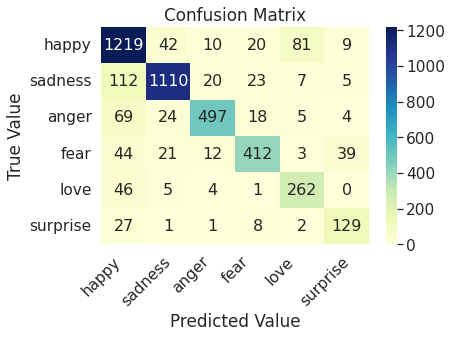

In [92]:
y_pred2 = [list(l).index(max(l)) for l in y_pred]
print_cf1(y_t,y_pred2)

In [49]:
df_test = pd.read_csv("df_kaggle_test.csv")
df_test["Emotion"].value_counts()

happy       1381
sadness     1277
anger        617
fear         531
love         318
surprise     168
Name: Emotion, dtype: int64

# prediction

In [63]:
phrase = pd.Series(["I am good"])
phrase_clean = hero.clean(phrase)
phrase_stop = hero.remove_stopwords(phrase_clean, custom_stopwords)
phrase_seq = tokenizer.texts_to_sequences(phrase_stop)
phrase_pad = pad_sequences(phrase_seq,maxlen=max_length,padding=padding_type, truncating=truncation_type)

pred = model.predict(phrase_pad)
indice = list(pred[0]).index(max(pred[0]))
labels_6[indice]

'happy'

# avec le dataset world

In [80]:
dfw = pd.read_csv("df_kaggle_dataworld_train.csv")

In [81]:
yw = dfw.pop("Emotion")
dfw['clean_text'] = hero.clean(dfw['Text'])
dfw['clean_text_stop'] = hero.remove_stopwords(dfw['clean_text'], custom_stopwords)

#token
tokenizerw = Tokenizer(num_words = 35000, oov_token=oov_token)
Xw = dfw["clean_text_stop"]
tokenizerw.fit_on_texts(Xw)
word_indexw = tokenizerw.word_index

In [83]:
len(word_indexw)
max([len(t.split()) for t in Xw])

37

In [87]:
max_length=37
X_sequencesw = tokenizer.texts_to_sequences(Xw)
X_paddedw = pad_sequences(X_sequencesw,maxlen=max_length,padding=padding_type, truncating=truncation_type)


In [85]:
# embeding matrix : les poids du modele glove pour les mots de notre texte
embedding_matrix = np.zeros((len(word_indexw) + 1,emb_length ))
for word, i in word_indexw.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [86]:
yw.replace(["happy","sadness","anger","fear","love","surprise"],[0,1,2,3,4,5],inplace=True)

dummy_yw = np_utils.to_categorical( yw)

In [88]:
embedding_layer = Embedding(input_dim=len(word_indexw) + 1,
                            output_dim=emb_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)


model = Sequential([
    embedding_layer,
    LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True),
    LSTM(100,dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(128, activation='relu'),
   Dense(6, activation='softmax')
])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_paddedw, dummy_yw, test_size=0.2, random_state=42)

model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
%load_ext tensorboard

#rm -rf logs

log_folder = 'logs_world/test1'
callbacks = [
            EarlyStopping(min_delta=0.001,patience = 10,restore_best_weights=True),
            TensorBoard(log_dir=log_folder, histogram_freq=1)
            ]


history = model.fit(X_train,y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/100
1213/1213 [==============================] - 94s 72ms/step - loss: 1.5010 - accuracy: 0.3875 - val_loss: 1.3851 - val_accuracy: 0.4486
Epoch 2/100
1213/1213 [==============================] - 87s 72ms/step - loss: 1.3767 - accuracy: 0.4469 - val_loss: 1.3326 - val_accuracy: 0.4666
Epoch 3/100
1213/1213 [==============================] - 90s 74ms/step - loss: 1.3226 - accuracy: 0.4799 - val_loss: 1.2832 - val_accuracy: 0.5124
Epoch 4/100
1213/1213 [==============================] - 87s 72ms/step - loss: 1.2714 - accuracy: 0.5083 - val_loss: 1.2262 - val_accuracy: 0.5353
Epoch 5/100
1213/1213 [==============================] - 88s 73ms/step - loss: 1.2240 - accuracy: 0.5308 - val_loss: 1.2123 - val_accuracy: 0.5255
Epoch 6/100
1213/1213 [==============================] - 88s 72ms/step - loss: 1.1908 - accuracy: 0.5450 - val_loss: 1.1969 - val_accuracy: 0.5397
Epoch 7/100
1213/1213 [=====